In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
#missin values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [10]:
# Fill missing age values with the median age
df['Age'].fillna(df['Age'].median(), inplace=True)

# Fill missing Embarked values with the most common port
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Drop the Cabin column if it exists, as it has too many missing values
if 'Cabin' in df.columns:
    df.drop('Cabin', axis=1, inplace=True)

/tmp/ipython-input-2282429763.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-2282429763.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [11]:
df.isnull().sum()
#removed missing values

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [14]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [30]:
X = df.drop('Survived', axis=1).values
y = df['Survived'].values

indices = np.random.permutation(len(X))
split = int(0.8 * len(X))

X_train = X[indices[:split]]
X_test  = X[indices[split:]]

y_train = y[indices[:split]]
y_test  = y[indices[split:]]

# CLEAN HERE
X_train = np.nan_to_num(X_train)
X_test  = np.nan_to_num(X_test)

# SCALE AFTER CLEANING
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

std[std == 0] = 1

X_train = (X_train - mean) / std
X_test  = (X_test - mean) / std

# ✅ VERIFY
np.isnan(X_train).sum(), np.isnan(X_test).sum()


(np.int64(0), np.int64(0))

In [31]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.losses = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y, y_hat):
        epsilon = 1e-9  # avoids log(0)
        return -np.mean(
            y * np.log(y_hat + epsilon) +
            (1 - y) * np.log(1 - y_hat + epsilon)
        )

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_hat = self.sigmoid(linear_model)

            # gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_hat - y))
            db = (1 / n_samples) * np.sum(y_hat - y)

            # update
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # store loss
            loss = self.compute_loss(y, y_hat)
            self.losses.append(loss)

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

model = LogisticRegression(learning_rate=0.01, epochs=1000)
model.fit(X_train, y_train)


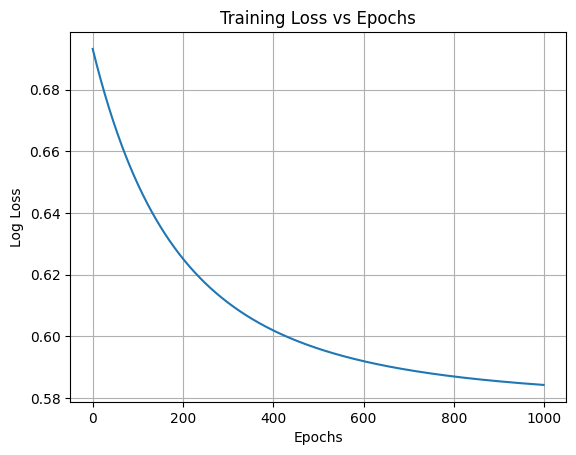

In [32]:
plt.plot(model.losses)
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()


In [33]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
TP = np.sum((y_test == 1) & (y_pred == 1))
TN = np.sum((y_test == 0) & (y_pred == 0))
FP = np.sum((y_test == 0) & (y_pred == 1))
FN = np.sum((y_test == 1) & (y_pred == 0))

print("Confusion Matrix")
print(f"TP: {TP}, FP: {FP}")
print(f"FN: {FN}, TN: {TN}")


Confusion Matrix
TP: 30, FP: 14
FN: 38, TN: 97


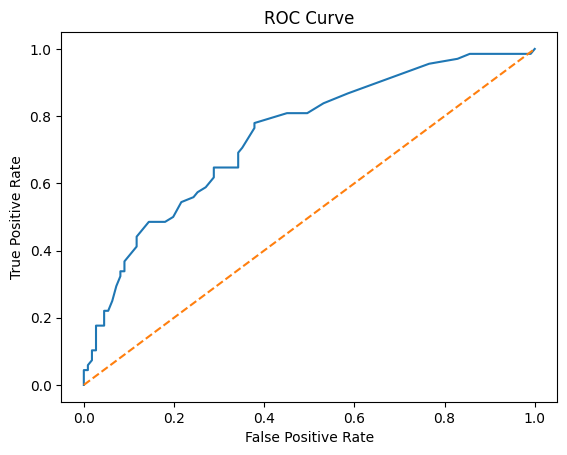

In [34]:
thresholds = np.linspace(0, 1, 100)
tpr = []
fpr = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)

    TP = np.sum((y_test == 1) & (preds == 1))
    TN = np.sum((y_test == 0) & (preds == 0))
    FP = np.sum((y_test == 0) & (preds == 1))
    FN = np.sum((y_test == 1) & (preds == 0))

    tpr.append(TP / (TP + FN + 1e-9))
    fpr.append(FP / (FP + TN + 1e-9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
